# Introdução
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O objetivo deste projeto é criar um site que determine o preço de um diamante com base em suas características: quilate (carat), corte (cut), cor (color), claridade (clarity), preço (price), profundidade (depth), tabela (table), comprimento (x), largura (y) e profundidade (z). No entanto, em situações onde é necessário estimar rapidamente o valor de um diamante, não é viável considerar todas essas características. Portanto, é necessário um estudo da base de dados para identificar as características mínimas necessárias para uma estimativa precisa do preço de um diamante.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para realizar este estudo, utilizaremos o modelo de projeto CRISP-DM (Cross-Industry Standard Process for Data Mining). O CRISP-DM possui seis etapas de planejamento do projeto: entendimento do negócio, entendimento dos dados, processamento de dados, modelagem, avaliação e implementação. Todos esses processos serão seguidos durante o estudo da base de dados Diamonds.

# **Etapa 1: Entendimento do negócio**

O primeiro passo do CRISP-DM é o entendimento do negócio, precisamos entender exatamente o que o cliente está precisando que façamos. Para tal, usaremos de 2 estratégias para resolver o problema, sendo a primera a criação de um DER (Diagrama de Entidade e Relacionamento), e a segunda sendo a criação de um processo ágil BDD (Behavior-Driven Development).

1) Para obter uma visão mais clara da base de dados, vamos começar criando um Diagrama de Entidade-Relacionamento como o mostrado abaixo.

<div align="center">
    <img src="DER.png" alt="descrição_da_imagem">
</div>

2) Usaremos o BDD para a realizar uma criação de cenários do nosso projeto, sendo tal o que está abaixo:

**Cenário 1**: Estimar um preço para o diamante

*COMO* um usuário,

*EU* quero descobrir o valor de um diamante,

*PARA* não ser enganado quando for realizar a venda de meu diamante.


# **Etapa 2: Entendimento dos dados**

Com o entendimento do negócio já estabelecido, agora passaremos para a segunda etapa do CRISP-DM: o Entendimento dos Dados. Para este processo, utilizaremos a base de dados "Diamonds", adquirida na plataforma Kaggle. Esta base de dados está em formato CSV e contém 10 colunas e 53.940 linhas.

## Características da base de dados
- **Carat:** É o quilate do diamante.
- **Cut:** É o tipo de corte do diamante.
- **Color:** É a cor do diamante.
- **Clarity:** É a pureza/claridade do diamante.
- **Price:** Preço do diamante.
- **Depth:** É a porcentagem total da profundidade do diamante.
- **Table:** Largura da parte superior do diamante em relação ao ponto mais largo.
- **x:** Comprimento do diamante.
- **y:** Largura do diamante.
- **z:** Profundidade do diamante.

# **Etapa 3: Preparação dos dados**

A seguir, vamos abordar o processo 3 do CRISP-DM: a preparação dos dados. Nesta etapa, importaremos algumas bibliotecas em Python e investigaremos a existência de valores incorretos ou ausentes na base de dados. Caso encontremos valores indesejados ou faltantes, realizaremos o tratamento necessário para garantir que não influenciem negativamente nos resultados das pesquisas do projeto.

In [218]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

In [219]:
#Mudar a path da base de dados 
path = r"DataBases\Diamonds_values_faltantes.csv"
diamonds = pd.read_csv(fr"{path}")

diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,NaN,61.2,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,NaN,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,NaN,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


Abaixo está a quantidade de valores faltantes por coluna

In [220]:
counter = {}
for x in range(diamonds.shape[1]):
    column_name = diamonds.columns[x]
    counter[column_name] = diamonds.shape[0] - len(diamonds[column_name].dropna())

counter_df = pd.DataFrame(list(counter.items()), columns=['Coluna', 'Quantidade de NaN'])
counter_df

,Coluna,Quantidade de NaN
0,carat,1649
1,cut,1556
2,color,1540
3,clarity,1476
4,depth,1421
5,table,1369
6,price,1340
7,x,1308
8,y,1253
9,z,1257


## **Tratando a base de dados usando o algorítimo K-NN (K-Nearest Neighbors)**

Colocando medições iguais a 0 de comprimento, largura e/ou profundidade de um diamante como NaN

In [221]:
for x in range(diamonds.shape[0]):
    for y in range(7, diamonds.shape[1]):
        if diamonds.iloc[x, y] == 0: diamonds.iloc[x, y] = np.nan
        elif diamonds.iloc[x, y] >= 30: diamonds.iloc[x, y] = np.nan
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,NaN,61.2,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,NaN,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,NaN,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


Para realizar o cálculo da distância do diamante, na qual queremos descobrir o preço, usaremos o cálculo da distância euclidiana:
$$d(A,B)= \sqrt{\sum_{i=1}^{n} (A_i - B_i)^2}$$

- A é o eixo do ponto que queremos prever o valor.
- B é o eixo de um ponto já definido.

In [222]:
'''KNN para valores categóricos'''
encoder = OrdinalEncoder()
diamonds_encoder = encoder.fit_transform(diamonds)

knn_imputer = KNNImputer(n_neighbors = round(math.log(diamonds.shape[0])), metric = "nan_euclidean")
test = knn_imputer.fit_transform(diamonds_encoder)


diamonds_imputer = pd.DataFrame(test, columns = diamonds.columns)
diamonds_imputer = encoder.inverse_transform(diamonds_imputer)
diamonds = pd.DataFrame(diamonds_imputer.tolist(), columns = diamonds.columns)

diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,VS1,61.2,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.22,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,Ideal,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


Salvando a base de dados já limpa e sem valores faltantes

In [223]:
path = r"DataBases\Diamonds_limpa.csv"
try:
    pd.read_csv(f"{path}")
    print(f"Já existe esse dataframe no diretório: {path}")
except FileNotFoundError:
    diamonds.to_csv(fr"{path}", index = False)
    print(f'''Base de dados limpa adicionada ao diretório:
          {path}
          com sucesso!!''')


Já existe esse dataframe no diretório: DataBases\Diamonds_limpa.csv


Por fim, tentamos salvar a base de dados sem nenhum valor faltante ou incorreto na pasta "Databases". Se conseguirmos, isso indica que a base de dados não estava previamente salva. Caso contrário, a base de dados já estava salva.

# **Etapa 4: Modelagem**

Para a quarta etapa do CRISP-DM, estaremos focando na parte central do projeto, que consiste no estudo aprofundado da base de dados. Nessa fase, nosso objetivo principal é identificar os principais fatores que influenciam o preço de um diamante.

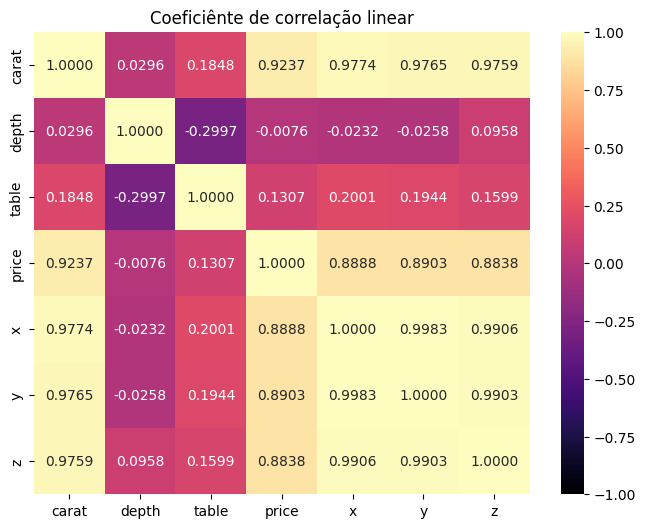

In [224]:
plt.figure(figsize = (8, 6))
sns.heatmap((diamonds[["carat", "depth", "table", "price", "x", "y", "z"]]).corr(), vmin = -1, vmax = 1, annot = True, cmap = 'magma', fmt = ".4f")
plt.title("Coeficiênte de correlação linear")
plt.show()

**Análise do heatmap acima com base no price(preço):**
- Podemos concluir que o price(preço) não tem uma correlação boa com a porcentagem total do diamante(depth) e também não tem uma correlação alta com o table, sendo uma correlação inversamente proporcional de -0,0086 com o depth, e uma relação proporcional de 0,13 com o table.
- Podemos concluir também que o preço tem uma boa correlação linear com o carat(quilate) de 0,92, x(comprimento) de 0,89, y(largura) de 0,89 e z(profundidade) de 0,88.

Com base nessa análise do heatmap, podemos concluir que quanto maior o carat(quilate), x(comprimento), y(largura) e z(profundidade), maior poderá ser o price(preço) do diamante.

Entretato, podem existir alguns casos, de se ter um diamante com um quilate muito alto porém com um preço baixo, assim como poderá existir diamantes com um quilate baixo mas com um preço alto. Tal, poderá também acontecer com o x(comprimento), y(largura) e z(profundidade), por causa disso nos questionamos o seguinte, quanto que o carat(quilate), x(comprimento), y(largura) e z(profundidade) conseguem determinar o valor do diamante? Para responder isso, precisamos tirar o Coeficiênte de Determinação.

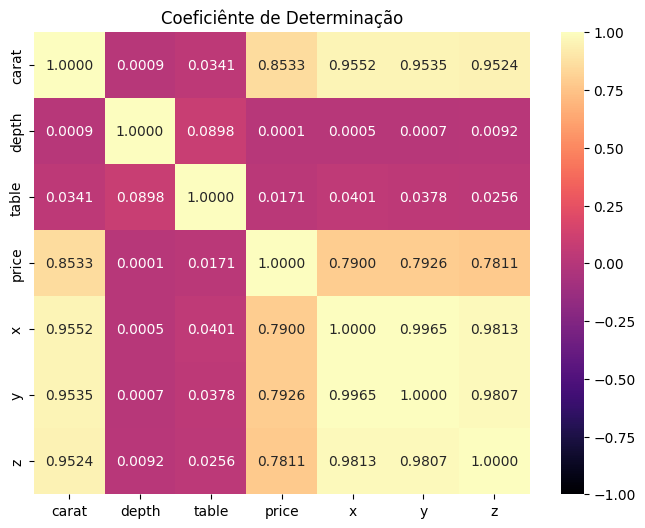

In [225]:
plt.figure(figsize = (8, 6))
sns.heatmap((diamonds[["carat", "depth", "table", "price", "x", "y", "z"]]).corr()**2, vmin = -1, vmax = 1, annot = True, cmap = 'magma', fmt = ".4f")
plt.title("Coeficiênte de Determinação")
plt.show()

**Análise do heatmap acima com base no price(preço):**

Ao analisarmos o heatmap acima, podemos perceber que podemos definir o preço do diamante com maior confiabilidade usando a variável numérica carat(quilate), com confiabilidade de 85%, isso significa que por mais que possamos dizer que quanto maior o quilate do diamante maior o seu preço, infelizmente essa regra só é de fato válida para 85% dos dados.

Já para x(comprimento), y(largura) e z(profundidade), essa confiabilidade é de apenas 79% para comprimento e largura, e 78% para profundidade, o que não é uma determinação forte, e por isso poderão ser desconsideradas caso as variáveis categóricas, consigam definir com precisão o preço do diamante.

Abaixo estamos realizando o processo de separação da base de dados diamonds. Para que assim, o processo de machine learn seja mais efetivo.

- Cut tem 5 tipos de classificação Ideal, Premium, Good, Very Good e Fair

- Color tem 7 tipos de classificação E, I, J, H, F, G e D

- Clarity tem 8 tipos de classificação SI2, SI1, VS1, VS2, VVS2, VVS1, I1 e IF

## **Análise da relação de preço das colunas numéricas**

**INFORMAÇÕES IMPORTANTES:**
- 1 Quilate equivale a 200mg
- 1 Ponto equivale a 0,01 quilates

O gráfico abaixo compara a relação do comprimento de um diamante com o carat e com o preço

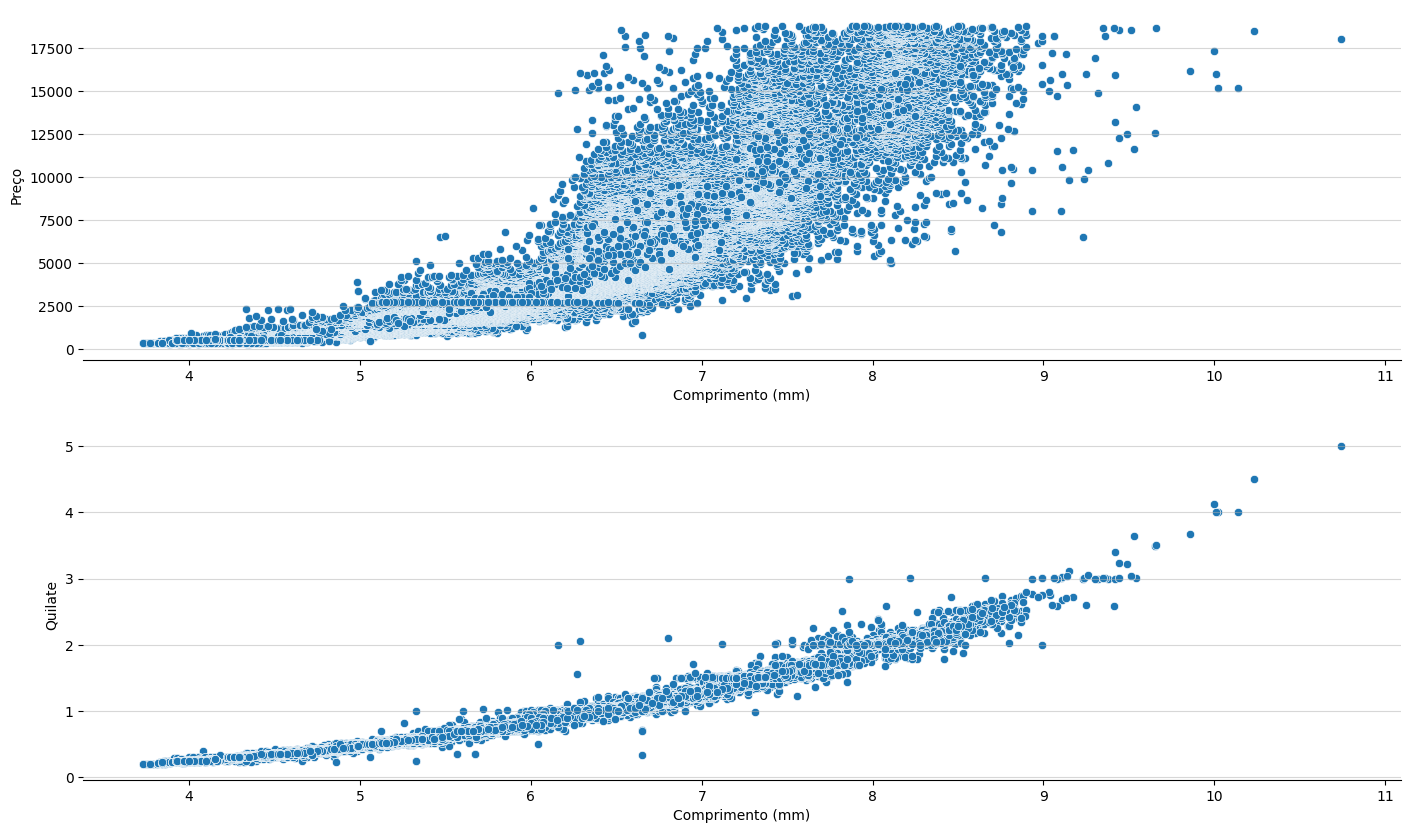

In [226]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(data=diamonds, x =  "x", y = "price")
plt.xlabel("Comprimento (mm)")
plt.ylabel("Preço")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.subplot(2, 1, 2)
sns.scatterplot(data=diamonds, x = "x", y = "carat")
plt.xlabel("Comprimento (mm)")
plt.ylabel("Quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

O gráfico abaixo compara a relação da largura de um diamante com o carat e com o preço

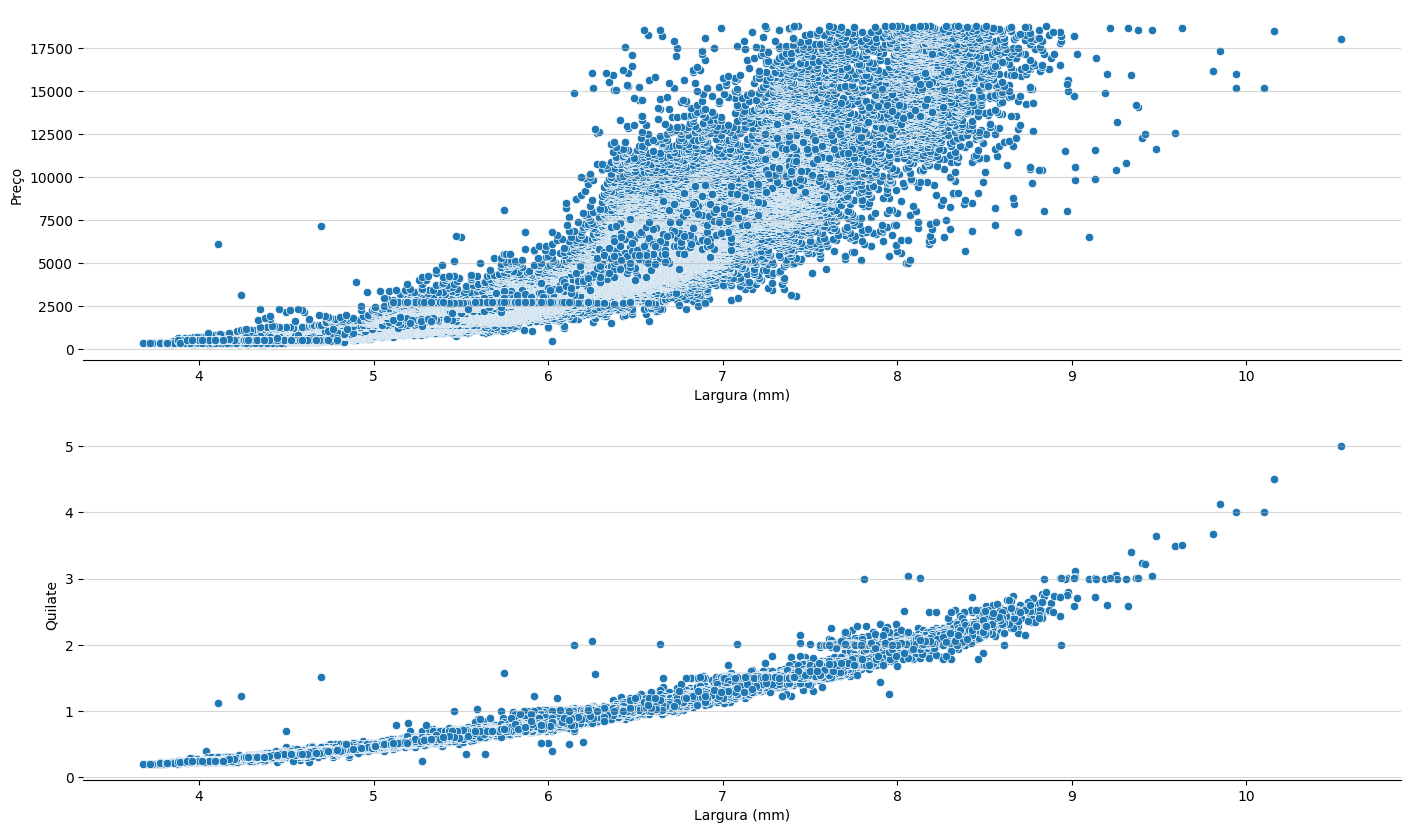

In [227]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(diamonds, x = "y", y = "price")
plt.xlabel("Largura (mm)")
plt.ylabel("Preço")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.subplot(2, 1, 2)
sns.scatterplot(diamonds, x = "y", y = "carat")

plt.xlabel("Largura (mm)")
plt.ylabel("Quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

O gráfico abaixo compara a relação da profundidade de um diamante com o carat e com o preço

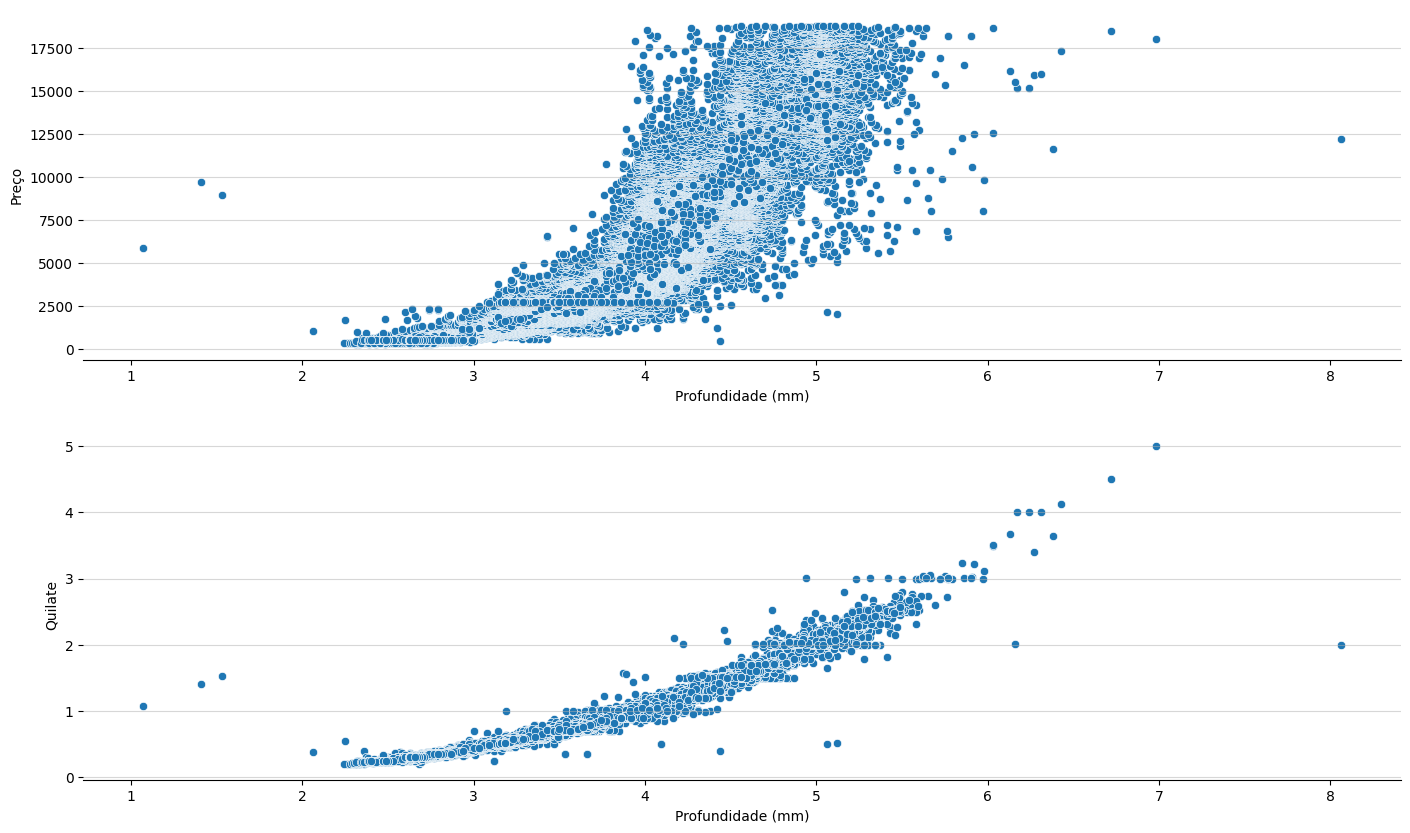

In [228]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(diamonds, x = "z", y = "price")
plt.xlabel("Profundidade (mm)")
plt.ylabel("Preço")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.subplot(2, 1, 2)
sns.scatterplot(diamonds, x = "z", y = "carat")
plt.xlabel("Profundidade (mm)")
plt.ylabel("Quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

O gráfico abaixo compara a relação do quilate de um diamante com o preço

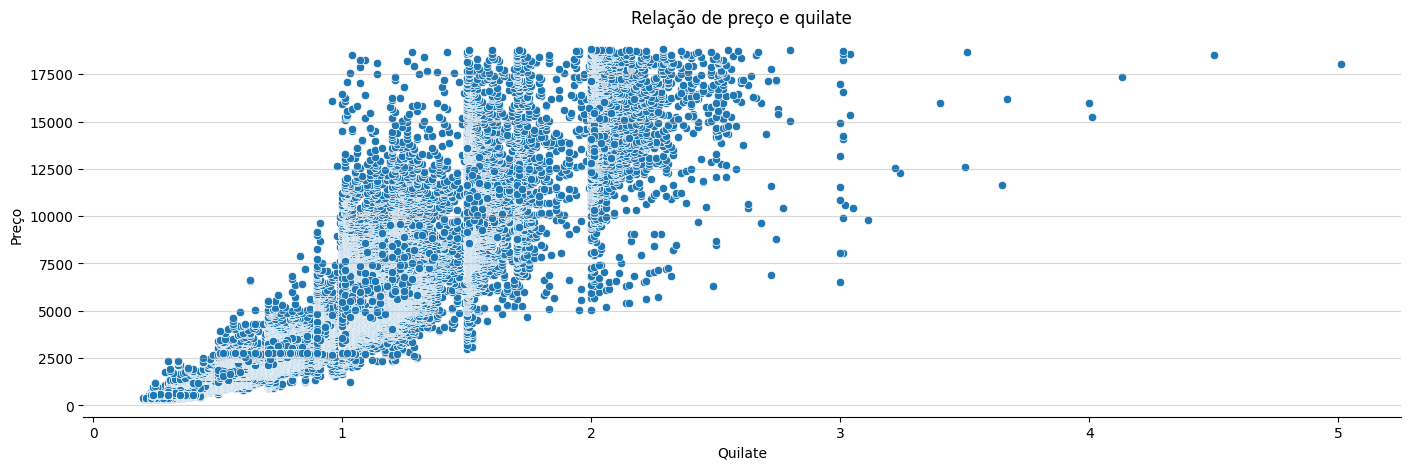

In [229]:
plt.figure(figsize=(17, 5))
sns.scatterplot(diamonds, x = "carat", y = "price")
plt.xlabel("Quilate")
plt.ylabel("Preço")
plt.title("Relação de preço e quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

Com base nos gráficos apresentados, é evidente que o comprimento, largura e profundidade de um diamante têm uma relação mais confiável com seu peso em quilates do que com seu preço. Portanto, ao determinar o valor de um diamante com o mínimo de medidas necessárias, podemos confiar nos dados de quilates fornecidos. As dimensões físicas, como comprimento, largura e profundidade, oferecem uma indicação mais precisa do peso do diamante do que do seu valor monetário.

Entretanto, é importante ressaltar que isso não significa que não podemos usar as medidas de comprimento, largura e profundidade para estimar o valor de um diamante. Pelo contrário, quanto mais informações tivermos, mais precisa será a estimativa do preço do diamante. No entanto, se tivermos que escolher o mínimo de informações para estimar o valor de um diamante, podemos afirmar que o quilate é suficiente para essa avaliação.

#### **Existem 3 formar de estimar o preço do diamante para o usuário do programa:**
1) Solicitar a massa do diamante para o cliente, e com isso realizar o cálculo:   
$$ \text{Quilate} = \frac{\text{Massa (mg)}}{200}$$

2) Quando o usuário fornece os pontos do diamante:
$$Quilate = \frac{\text{Pontos (pt)}}{100}$$

3) Para a segunda forma de estimar o quilate do diamante, é necessário 4 coisas: Comprimento (mm), Largura (mm), Profundidade (mm) e densidade ($\frac{mm}{mm³}$). Com isso utilizaremos o cálculo da densidade de um objeto, para assim cálcular primeiramante a massa do diamante: $$Densidade = \frac{Massa}{Volume} \rightarrow Massa = Densidade \times Volume $$ Entretanto temos um problema, não temos o volume do diamante, entretanto para isso, iremos dismenbrar o cálculo do volume de um objeto, sendo: $$Volume = Comprimento \times Largura \times Profundidade$$ Substituindo na fórmula então, ficará: $$Massa = Comprimento \times Largura \times Profundidade \times Densidade$$ Agora teremos de descobrir o quilate do diamante, para isso, usaremos a forma 1 de estimar o cálculo do diamante: $$Quilate = \frac{Massa (mg)}{200}$$ Ficando na fórmula geral: $$Quilate = \frac{Densidade \times Volume}{200}$$ $$\text{OU}$$  $$Quilate = \frac{Comprimento \times Largura \times Profundidade \times Densidade}{200} $$

## **Relação de preço com as colunas categóricas**

In [230]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.00000
mean,0.797388,61.751368,57.439803,3931.331201,5.730953,5.733120,3.53925
std,0.473151,1.406329,2.201157,3977.347590,1.117914,1.109959,0.69108
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.07000
25%,0.400000,61.100000,56.000000,949.000000,4.710000,4.720000,2.91000
50%,0.700000,61.800000,57.000000,2405.000000,5.700000,5.710000,3.53000
75%,1.040000,62.500000,59.000000,5358.000000,6.540000,6.540000,4.03000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,10.540000,8.06000


In [231]:
description = diamonds.describe()
price = [f"until ${description.iloc[4, 3]}", 
    f"until ${description.iloc[5, 3]}",
    f"until ${description.iloc[6, 3]}",
    f"greater than ${description.iloc[6, 3]}"]

carat = [f"until ${description.iloc[4, 0]}", 
    f"until ${description.iloc[5, 0]}",
    f"until ${description.iloc[6, 0]}",
    f"greater than ${description.iloc[6, 0]}"]

    
def agrupamento(diamonds, coluna, index_coluna: list):
    if coluna == "price":
        coluna_aux = 3
    else:
        coluna_aux = 0

    description = diamonds.describe()
    cut = pd.DataFrame({"Fair": [0.0 for x in range(4)],
                        "Good": [0.0 for x in range(4)],
                        "Very Good": [0.0 for x in range(4)],
                        "Premium": [0.0 for x in range(4)],
                        "Ideal": [0.0 for x in range(4)]}, 
                        index = index_coluna)

    color = pd.DataFrame({"J": [0.0 for x in range(4)],
                        "D": [0.0 for x in range(4)],
                        "I": [0.0 for x in range(4)],
                        "E": [0.0 for x in range(4)],
                        "F": [0.0 for x in range(4)],
                        "H": [0.0 for x in range(4)],
                        "G": [0.0 for x in range(4)]}, 
                        index = index_coluna)

    clarity = pd.DataFrame({"I1": [0.0 for x in range(4)],
                            "IF": [0.0 for x in range(4)],
                            "VVS1": [0.0 for x in range(4)],
                            "VVS2": [0.0 for x in range(4)],
                            "VS1": [0.0 for x in range(4)],
                            "VS2": [0.0 for x in range(4)],
                            "SI2": [0.0 for x in range(4)],
                            "SI1": [0.0 for x in range(4)]}, 
                            index = index_coluna)

    for intervalo in ["25%", "50%", "75%", "max"]:
        if intervalo == "25%":
            diamonds_aux = diamonds[diamonds[coluna] <= diamonds.describe()[coluna][intervalo]].reset_index()
            
        elif intervalo == "50%":
            diamonds_aux = diamonds[diamonds[coluna] > diamonds.describe()[coluna]["25%"]].reset_index()
            diamonds_aux = diamonds_aux[diamonds_aux[coluna] <= diamonds.describe()[coluna][intervalo]].reset_index()
            
        elif intervalo == "75%":
            diamonds_aux = diamonds[diamonds[coluna] > diamonds.describe()[coluna]["50%"]].reset_index()
            diamonds_aux = diamonds_aux[diamonds_aux[coluna] <= diamonds.describe()[coluna][intervalo]].reset_index()
            
        else:
            diamonds_aux = diamonds[diamonds[coluna] > diamonds.describe()[coluna]["75%"]].reset_index()
        
        describe = diamonds.describe()[coluna][intervalo]
        
        for x in range(diamonds_aux.shape[0]):
            for y in range(cut.shape[1]):
                if diamonds_aux.loc[x, "cut"] == cut.columns[y]:
                    try:
                        cut.loc[f"until ${describe}", cut.columns[y]] += 1.0
                    except KeyError:
                        cut.loc[f"greater than ${description.iloc[6, coluna_aux]}", cut.columns[y]] += 1.0
                    break
                
            for y in range(color.shape[1]):
                if diamonds_aux.loc[x, "color"] == color.columns[y]:
                    try:
                        color.loc[f"until ${describe}", color.columns[y]] += 1.0
                    except KeyError:
                        color.loc[f"greater than ${description.iloc[6, coluna_aux]}", color.columns[y]] += 1.0
                    break
                
            for y in range(clarity.shape[1]):
                if diamonds_aux.loc[x, "clarity"] == clarity.columns[y]:
                    try:
                        clarity.loc[f"until ${describe}", clarity.columns[y]] += 1.0
                    except (KeyError, KeyboardInterrupt):
                        clarity.loc[f"greater than ${description.iloc[6, coluna_aux]}", clarity.columns[y]] += 1.0
                    break

    soma_cut = [sum(cut.iloc[:, x]) for x in range(cut.shape[1])]
    soma_color = [sum(color.iloc[:, x]) for x in range(color.shape[1])]
    soma_clarity = [sum(clarity.iloc[:, x]) for x in range(clarity.shape[1])]

    for x in range(4):
        for y in range(cut.shape[1]):
            cut.iloc[x, y] = round(cut.iloc[x, y] / soma_cut[y], 4).astype(float)
        for y in range(color.shape[1]):
            color.iloc[x, y] = round(color.iloc[x, y] / soma_color[y], 4).astype(float)
        for y in range(clarity.shape[1]):
            clarity.iloc[x, y] = round(clarity.iloc[x, y] / soma_clarity[y], 4).astype(float)

    if "carat" == coluna:
        cut.index = [f"until {description.iloc[4, 0]}", 
                    f"until {description.iloc[5, 0]}",
                    f"until {description.iloc[6, 0]}",
                    f"greater than {description.iloc[6, 0]}"]
        
        color.index = [f"until {description.iloc[4, 0]}", 
                    f"until {description.iloc[5, 0]}",
                    f"until {description.iloc[6, 0]}",
                    f"greater than {description.iloc[6, 0]}"]
        
        clarity.index = [f"until {description.iloc[4, 0]}", 
                    f"until {description.iloc[5, 0]}",
                    f"until {description.iloc[6, 0]}",
                    f"greater than {description.iloc[6, 0]}"]
        

    return cut, color, clarity

In [232]:
cut, color, clarity = agrupamento(diamonds, "price", price)
cut_carat, color_carat, clarity_carat = agrupamento(diamonds, "carat", carat)

O comando acima cria seis tabelas que exibem, em porcentagens, a quantidade de diamantes com determinadas características dentro de intervalos de valores específicos. Além disso, são geradas outras três tabelas semelhantes, mas, em vez de agrupar os dados pelo preço, eles são agrupados pelo peso em quilates (carat).

In [233]:
cut

,Fair,Good,Very Good,Premium,Ideal
until $949.0,0.0532,0.2163,0.2579,0.2142,0.2886
until $2405.0,0.2854,0.2196,0.2114,0.2191,0.2926
until $5358.0,0.4208,0.3346,0.2786,0.2549,0.2027
greater than $5358.0,0.2405,0.2295,0.2520,0.3119,0.2161


In [234]:
cut_carat

,Fair,Good,Very Good,Premium,Ideal
until 0.4,0.0423,0.1925,0.2452,0.2360,0.3300
until 0.7,0.2168,0.2339,0.2260,0.1895,0.2713
until 1.04,0.4554,0.3646,0.2951,0.2496,0.1850
greater than 1.04,0.2854,0.2089,0.2337,0.3249,0.2137


Ao analisarmos os gráficos acima, podemos identificar quais cortes tendem a ter maiores pesos em quilates e preços, e quais cortes tendem a ter menores pesos em quilates e preços. Observamos que o corte influencia mais o peso em quilates do que o preço. No entanto, o corte pode nos auxiliar na determinação do intervalo de valores em que o diamante se enquadra. Uma vez definido o quilate, torna-se mais claro determinar um intervalo de preços para o diamante, permitindo assim uma estimativa mais precisa do seu valor.

In [235]:
color

,J,D,I,E,F,H,G
until $949.0,0.1540,0.2800,0.2155,0.2863,0.2416,0.2386,0.2551
until $2405.0,0.1852,0.3030,0.1631,0.3109,0.2762,0.1709,0.2538
until $5358.0,0.2754,0.2505,0.2695,0.2495,0.2643,0.2761,0.2041
greater than $5358.0,0.3854,0.1665,0.3518,0.1532,0.2179,0.3144,0.2870


In [236]:
color_carat

,J,D,I,E,F,H,G
until 0.4,0.1183,0.3228,0.1941,0.3316,0.2673,0.2340,0.2730
until 0.7,0.1292,0.3038,0.1411,0.2992,0.2663,0.1594,0.2374
until 1.04,0.2175,0.2523,0.2204,0.2536,0.2902,0.2367,0.2328
greater than 1.04,0.5349,0.1211,0.4444,0.1156,0.1761,0.3699,0.2568


Diferentemente dos gráficos de corte (cut), podemos notar uma separação mais clara nos intervalos de valores ao analisar as cores dos diamantes. Isso nos permite observar com maior precisão quais cores têm uma tendência maior de apresentar quilates elevados e quais tendem a ter quilates mais baixos. Também conseguimos identificar quais cores de diamantes estão associadas a preços mais altos e quais tendem a ter valores mais baixos. Assim como o corte, a cor pode ser utilizada para estimar o preço do diamante, pois oferece uma indicação mais clara das tendências de preço e quilate.

In [237]:
clarity

,I1,IF,VVS1,VVS2,VS1,VS2,SI2,SI1
until $949.0,0.0738,0.3494,0.3860,0.3531,0.2853,0.2813,0.1161,0.2196
until $2405.0,0.2496,0.4077,0.3726,0.3001,0.2698,0.2558,0.1698,0.2189
until $5358.0,0.4298,0.0938,0.1201,0.1308,0.1761,0.1776,0.4333,0.3190
greater than $5358.0,0.2468,0.1491,0.1213,0.2161,0.2688,0.2853,0.2809,0.2425


In [238]:
clarity_carat

,I1,IF,VVS1,VVS2,VS1,VS2,SI2,SI1
until 0.4,0.0255,0.5999,0.5525,0.4317,0.3080,0.2954,0.0870,0.1815
until 0.7,0.1191,0.2132,0.2659,0.2786,0.2729,0.2538,0.1553,0.2415
until 1.04,0.3021,0.0903,0.0993,0.1480,0.2062,0.2247,0.3540,0.3157
greater than 1.04,0.5532,0.0967,0.0823,0.1418,0.2128,0.2261,0.4037,0.2613


Assim como vimos em cut(corte) e color(cor), a clarity(claridade) também é uma boa característica para poder descobrir o price(preço) do diamante, já que assim como as outras características, a mesma tem uma precisão maior ao definir um valor para carat(quilate) do que para o preço do diamante. Também conseguimos identificar quais claridades do diamantes estão associadas a preços mais altos e quais tendem a ter valores mais baixos. Assim como o corte, a cor pode ser utilizada para estimar o preço do diamante, pois oferece uma indicação mais clara das tendências de preço e quilate.

Contudo, podemos afirmar que as colunas categóricas da base de dados são essenciais para estimar o valor do diamante. Elas fornecem informações cruciais que permitem uma estimativa do preço da joia, auxiliando na determinação do valor do diamante. Portanto, essas colunas devem ser consideradas variáveis obrigatórias para o usuário ao realizar essa análise.

# **Etapa 5: Avaliação**

Na penúltima etapa do CRISP-DM, é crucial avaliar o desempenho do modelo de previsão adotado. Nesse contexto, utilizaremos a biblioteca scikit-learn para empregar o coeficiente de determinação (R²). Esse coeficiente nos auxilia na avaliação da precisão do modelo tanto para substituir valores faltantes na base de dados quanto para estimar o valor de diamantes fornecidos pelos usuários.

In [239]:
# Transformando as variáveis categóricas em numéricas
encoder = OrdinalEncoder()
diamonds_encoder = encoder.fit_transform(diamonds.drop(columns=['price']))

# Colocando essas alterações na base de dados
X = pd.DataFrame(diamonds_encoder.tolist(), columns = list(diamonds.columns).remove("price"))
y = diamonds['price']

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criar e treinar o modelo KNN  # valor de K baseado no log do número de observações
knn = KNeighborsRegressor(n_neighbors = int(round(math.log(diamonds.shape[0]), 0)))
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
r2 = r2_score(y_test, y_pred)
print(f'R² (Coeficiente de Determinação): {r2 * 100:.2f}%')

R² (Coeficiente de Determinação): 90.98%


Com base no programa acima, podemos concluir que a confiabilidade do algoritmo KNN é de 90,98%. Isso significa que, ao prever o preço de um diamante fornecido pelo usuário, o programa tem uma precisão de 90,98%.

# **Etapa 6: Implementação**

Por fim, a implementação é a última etapa do CRISP-DM. Nesta fase, colocamos em prática o projeto estudado. Agora que conhecemos o nível de confiabilidade do algoritmo e as variáveis mínimas que são importantes para a estimativa do preço do diamante, podemos implementar nosso estudo no projeto final. Isso significa que podemos utilizar todo o conhecimento e o modelo desenvolvido para prever o preço de um diamante de forma eficaz e precisa. Por isso o passo final é realizar o programa que prever o valor do diamante.